# Neural Networks - Street View Housing Number Digit Recognition

**The Problem Description:**

Recognizing multi-digit numbers in photographs captured at street level is an important component of modernday map making. A classic example of a corpus of such street-level photographs is Google’s Street View
imagery comprised of hundreds of millions of geo-located 360-degree panoramic images. The ability to
automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed
number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building
it represents. More broadly, recognizing numbers in photographs is a problem of interest to the optical
character recognition community. While OCR on constrained domains like document processing is well
studied, arbitrary multi-character text recognition in photographs is still highly challenging. This difficulty arises
due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts,
colours, styles, orientations, and character arrangements. The recognition problem is further complicated by
environmental factors such as lighting, shadows, specularities, and occlusions as well as by image acquisition
factors such as resolution, motion, and focus blurs. In this project, we will use the dataset with images centred
around a single digit (many of the images do contain some distractors at the sides). Although we are taking a
sample of the data which is simpler, it is more complex than MNIST because of the distractors.

**Dataset:**

SVHN is a real-world image dataset for developing machine learning and object recognition algorithms with the
minimal requirement on data formatting but comes from a significantly harder, unsolved, real-world problem
(recognizing digits and numbers in natural scene images). SVHN is obtained from house numbers in Google
Street View images.

In [309]:
# Import required libraries

import h5py
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Activation, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
infile = h5py.File('SVHN_single_grey1.h5','r')

In [3]:
infile.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [4]:
X_train1 = infile['X_train'][:]
X_test1 = infile['X_test'][:]
X_val1 = infile['X_val'][:]
y_train1 = infile['y_train'][:]
y_test1 = infile['y_test'][:]
y_val1 = infile['y_val'][:]

In [5]:
# backup
X_train = X_train1.copy()
X_test = X_test1.copy()
X_val = X_val1.copy()
y_train = y_train1.copy()
y_test = y_test1.copy()
y_val = y_val1.copy()

In [6]:
print("Shape of X_train : ", X_train.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of X_test : ", X_test.shape)
print("Shape of y_test : ", y_test.shape)
print("Shape of X_val : ", X_val.shape)
print("Shape of y_val : ", y_val.shape)

Shape of X_train :  (42000, 32, 32)
Shape of y_train :  (42000,)
Shape of X_test :  (18000, 32, 32)
Shape of y_test :  (18000,)
Shape of X_val :  (60000, 32, 32)
Shape of y_val :  (60000,)


Size of each image is 32X32 pixels. Training, Validation and Test set contains 42000, 60000 and 18000 images respectively.

In [7]:
print('\nMinimum value in the array : ', X_train.min()) # minimum value in the array. values will be in the range of 0 to 255
print('\nMaximum value in the array : ', X_train.max()) # maximum value in the array


Minimum value in the array :  0.0

Maximum value in the array :  254.9745


In [8]:
print("Randomly selected an array from X_train - \n")
print(X_train[0]) # prints the 32X32 array

Randomly selected an array from X_train - 

[[ 33.0704  30.2601  26.852  ...  71.4471  58.2204  42.9939]
 [ 25.2283  25.5533  29.9765 ... 113.0209 103.3639  84.2949]
 [ 26.2775  22.6137  40.4763 ... 113.3028 121.775  115.4228]
 ...
 [ 28.5502  36.212   45.0801 ...  24.1359  25.0927  26.0603]
 [ 38.4352  26.4733  23.2717 ...  28.1094  29.4683  30.0661]
 [ 50.2984  26.0773  24.0389 ...  49.6682  50.853   53.0377]]


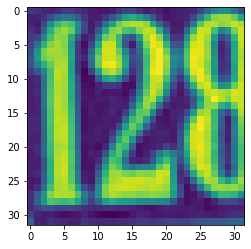

In [9]:
plt.imshow(X_train[0]) #display the image in index position 0
plt.show()

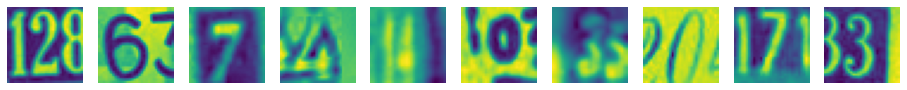

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [10]:
# visualizing the first 10 images in the dataset and their labels

plt.figure(figsize=(16, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i])
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train[0:10]))

**In the images, apart from target values, other values are also present. For example, the first image contains value 128 but the label has 2. For some images, unwanted information is present on both sides target value.**

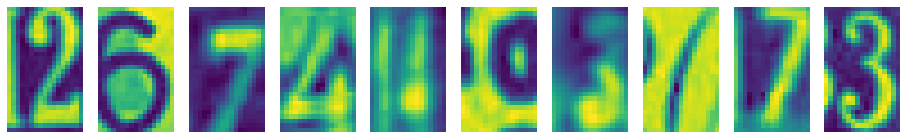

label for each of the above image: [2 6 7 4 4 0 3 0 7 3]


In [11]:
# checking how the image looks with cropping  
plt.figure(figsize=(16, 4))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(X_train[i][2:30,5:22]) # selects the rows from index 2 and until 30, and columns from index 5 and until 22.
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_train1[0:10]))

### After crop, values on the both sides of target values are removed. Neural networks will be built for both Full image and Cropped Image data

In [15]:
#cropped images are stored in _temp variables
X_train_temp = X_train[:,2:30,5:22]
X_val_temp = X_val[:,2:30,5:22]
X_test_temp = X_test[:,2:30,5:22]

print("Shape of X_train, X_val and X_test after cropping")
print(X_train_temp.shape)
print(X_val_temp.shape)
print(X_test_temp.shape)

Shape of X_train, X_val and X_test after cropping
(42000, 28, 17)
(60000, 28, 17)
(18000, 28, 17)


**Original image has 32X32 pixels, cropped image has 28X17 pixels**

In [19]:
# reshaping X data: (n, 32, 32) => (n, 1024). Full image data is reshaped.
X_train_fi_re = X_train.reshape((X_train.shape[0], -1)) #.reshaped 32*32 array into single dimensional 1024 size array 
X_test_fi_re = X_test.reshape((X_test.shape[0], -1))
X_val_fi_re = X_val.reshape((X_val.shape[0], -1))

In [25]:
# reshaping X data: (n, 32, 32) => (n, 1024). Cropped image data is reshaped.
X_train_ci_re = X_train_temp.reshape((X_train_temp.shape[0], -1)) #.reshaped 32*32 array into single dimensional 1024 size array 
X_test_ci_re = X_test_temp.reshape((X_test_temp.shape[0], -1))
X_val_ci_re = X_val_temp.reshape((X_val_temp.shape[0], -1))

In [21]:
# converting y data into categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [363]:
print("Before One hot encoding : ", y_train1[0])
print("After One hot encoding  : ", y_train[0])

Before One hot encoding :  2
After One hot encoding  :  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


    After encoding, index position 2 is marked as 1, and remaining with 0's.

In [23]:
print("Shape of X_train : ", X_train_fi_re.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of X_test : ", X_test_fi_re.shape)
print("Shape of y_test : ", y_test.shape)
print("Shape of X_val : ", X_val_fi_re.shape)
print("Shape of y_val : ", y_val.shape)

Shape of X_train :  (42000, 1024)
Shape of y_train :  (42000, 10)
Shape of X_test :  (18000, 1024)
Shape of y_test :  (18000, 10)
Shape of X_val :  (60000, 1024)
Shape of y_val :  (60000, 10)


In [26]:
print("Shape of X_train : ", X_train_ci_re.shape)
print("Shape of y_train : ", y_train.shape)
print("Shape of X_test : ", X_test_ci_re.shape)
print("Shape of y_test : ", y_test.shape)
print("Shape of X_val : ", X_val_ci_re.shape)
print("Shape of y_val : ", y_val.shape)

Shape of X_train :  (42000, 476)
Shape of y_train :  (42000, 10)
Shape of X_test :  (18000, 476)
Shape of y_test :  (18000, 10)
Shape of X_val :  (60000, 476)
Shape of y_val :  (60000, 10)


**Before Reshape:**
    * Each image in X_train is represented by 32X32 array. 
    * y_train had single column to represent label
    
**After Reshape:** 
    * In full image X_train, multi dimentional 32X32 array reshaped into single dimensional array of size 1024.
    * In cropped image X_train, multi dimentional 28X17 array reshaped into single dimensional array of size 476.
    * In y_train, instead of single column(label), 10 columns were created as part of one hot encoding.

In [28]:
print("Minimum value in X_train - ")
print(X_train_fi_re.min(), X_train_ci_re.min())
print("Maximum value in X_train - ") 
print(X_train_fi_re.max(), X_train_ci_re.max())

Minimum value in X_train - 
0.0 0.0
Maximum value in X_train - 
254.9745 254.9745


In [29]:
# Normalize the Train, Validation and Test sets. Get the values in the range of 0 to 1
X_train_fi = X_train_fi_re / 255.0
X_val_fi = X_val_fi_re / 255.0
X_test_fi = X_test_fi_re / 255.0
X_train_ci = X_train_ci_re / 255.0
X_val_ci = X_val_ci_re / 255.0
X_test_ci = X_test_ci_re / 255.0

In [30]:
print("Min and Max values after normalization -")
print(X_train_fi.min(), X_train_fi.max())
print(X_train_ci.min(), X_train_ci.max())

Min and Max values after normalization -
0.0 0.9999
0.0 0.9999


* X_train_fi, X_val_fi and X_test_fi denotes the data of FULL image.


* X_train_ci, X_val_ci and X_test_ci denotes the data of CROPPED image.

### 1. Build neural networks with single hidden layer

### NN for Full image

In [35]:
import tensorflow as tf
tf.keras.backend.clear_session()

mod1 = Sequential()
mod1.add(Dense(777, input_shape = (1024,), activation='relu', name='Hidden_Layer_1')) #first hidden layer with 777 neurons, and activation function relu.
mod1.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer is used
mod1.fit(X_train_fi, y_train, batch_size = 200, validation_data=(X_val_fi,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 7s 162us/sample - loss: 2.2851 - accuracy: 0.1581 - val_loss: 2.1244 - val_accuracy: 0.2910
Epoch 2/50
42000/42000 [==============================] - 6s 135us/sample - loss: 1.8958 - accuracy: 0.3919 - val_loss: 1.6555 - val_accuracy: 0.5112
Epoch 3/50
42000/42000 [==============================] - 6s 144us/sample - loss: 1.5154 - accuracy: 0.5415 - val_loss: 1.3945 - val_accuracy: 0.5741
Epoch 4/50
42000/42000 [==============================] - 6s 137us/sample - loss: 1.3132 - accuracy: 0.6103 - val_loss: 1.2287 - val_accuracy: 0.6358
Epoch 5/50
42000/42000 [==============================] - 6s 143us/sample - loss: 1.1889 - accuracy: 0.6461 - val_loss: 1.1356 - val_accuracy: 0.6655
Epoch 6/50
42000/42000 [==============================] - 6s 143us/sample - loss: 1.1176 - accuracy: 0.6667 - val_loss: 1.0667 - val_accuracy: 0.6873
Epoch 7/50
42000/42000 [==========================

In [36]:
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer_1 (Dense)              (None, 777)               796425    
_________________________________________________________________
Output (Dense)               (None, 10)                7780      
Total params: 804,205
Trainable params: 804,205
Non-trainable params: 0
_________________________________________________________________


In [46]:
result = mod1.evaluate(X_test_fi, y_test)

18000/18000 [==============================] - 3s 152us/sample - loss: 0.6546 - accuracy: 0.8147


    * On full image data, Neural networks with single hidden layer gave an accuracy of 81%.

In [51]:
#Store the Accuracy in a dataframe for final comparison
final_df = pd.DataFrame({'Models':['FI_1Lyr'], 'Accuracy': result[1]},index={'1'})
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722


In [40]:
#check the performance if we have a Flatten layer (input data with 32X32 pixels is passed as input)
tf.keras.backend.clear_session()

mod2 = Sequential()
mod2.add(Flatten()) #Flatten layer is added to network architecture
mod2.add(Dense(777, activation='relu', name='Hidden_Layer_1')) #First hidden layer with 777 neurons
mod2.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer is used
mod2.fit(X_train, y_train, batch_size = 200, validation_data=(X_val,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 7s 158us/sample - loss: 78.6932 - accuracy: 0.1055 - val_loss: 6.0189 - val_accuracy: 0.1134
Epoch 2/50
42000/42000 [==============================] - 6s 139us/sample - loss: 6.2298 - accuracy: 0.1306 - val_loss: 4.6194 - val_accuracy: 0.1567
Epoch 3/50
42000/42000 [==============================] - 6s 143us/sample - loss: 3.7215 - accuracy: 0.1693 - val_loss: 2.7636 - val_accuracy: 0.1991
Epoch 4/50
42000/42000 [==============================] - 6s 146us/sample - loss: 2.7922 - accuracy: 0.2199 - val_loss: 2.7213 - val_accuracy: 0.2401
Epoch 5/50
42000/42000 [==============================] - 6s 142us/sample - loss: 2.3115 - accuracy: 0.2806 - val_loss: 2.0254 - val_accuracy: 0.3308
Epoch 6/50
42000/42000 [==============================] - 6s 141us/sample - loss: 1.9759 - accuracy: 0.3423 - val_loss: 1.8824 - val_accuracy: 0.3857
Epoch 7/50
42000/42000 [=========================

In [41]:
mod2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
Hidden_Layer_1 (Dense)       multiple                  796425    
_________________________________________________________________
Output_Layer (Dense)         multiple                  7780      
Total params: 804,205
Trainable params: 804,205
Non-trainable params: 0
_________________________________________________________________


In [52]:
result = mod2.evaluate(X_test, y_test)

18000/18000 [==============================] - 3s 166us/sample - loss: 1.0687 - accuracy: 0.6816


    * On full image data, Neural networks with Flatten and single hidden layer gave an accuracy of 68%. 

In [59]:
temp_df = pd.DataFrame({'Models':['FI_1Lyr_Flatten'], 'Accuracy': [result[1]]},index={'2'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722
2,FI_1Lyr_Flatten,0.681556


### NN for CROPPED image

In [70]:
import tensorflow as tf
tf.keras.backend.clear_session()

mod1 = Sequential()
mod1.add(Dense(340, input_shape = (476,), activation='relu', name='Hidden_Layer_1')) #first hidden layer with 340 neurons, and activation function relu.
mod1.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer is used
mod1.fit(X_train_ci, y_train, batch_size = 200, validation_data=(X_val_ci,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 2s 45us/sample - loss: 2.1330 - accuracy: 0.2748 - val_loss: 1.8263 - val_accuracy: 0.4192
Epoch 2/50
42000/42000 [==============================] - 2s 38us/sample - loss: 1.5956 - accuracy: 0.5419 - val_loss: 1.4100 - val_accuracy: 0.6065
Epoch 3/50
42000/42000 [==============================] - 2s 39us/sample - loss: 1.2972 - accuracy: 0.6293 - val_loss: 1.1981 - val_accuracy: 0.6598
Epoch 4/50
42000/42000 [==============================] - 2s 39us/sample - loss: 1.1443 - accuracy: 0.6694 - val_loss: 1.0833 - val_accuracy: 0.6867
Epoch 5/50
42000/42000 [==============================] - 2s 39us/sample - loss: 1.0510 - accuracy: 0.6962 - val_loss: 1.0243 - val_accuracy: 0.7017
Epoch 6/50
42000/42000 [==============================] - 2s 39us/sample - loss: 0.9859 - accuracy: 0.7131 - val_loss: 0.9610 - val_accuracy: 0.7220
Epoch 7/50
42000/42000 [==============================] 

In [72]:
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 340)               162180    
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                3410      
Total params: 165,590
Trainable params: 165,590
Non-trainable params: 0
_________________________________________________________________


In [74]:
res1 = mod1.evaluate(X_test_ci, y_test)

18000/18000 [==============================] - 1s 42us/sample - loss: 0.5877 - accuracy: 0.8381


In [75]:
temp_df = pd.DataFrame({'Models':['CI_1Lyr'], 'Accuracy': [res1[1]]},index={'3'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722
2,FI_1Lyr_Flatten,0.681556
3,CI_1Lyr,0.838056


**With single layer, NN on cropped image gives better accuracy than NN on full image.**

### 2. Build neural networks with Two hidden layers

### Two hidden layer NN for Full image

In [76]:
import tensorflow as tf
tf.keras.backend.clear_session()

mod1 = Sequential()
mod1.add(Dense(777, input_shape = (1024,), activation='relu', name='Hidden_Layer_1')) #first hidden layer with 777 neurons, and activation function relu.
mod1.add(Dense(340, activation='relu', name='Hidden_Layer_2')) #second hidden layer with 340 neurons, and activation function relu.
mod1.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer is used
mod1.fit(X_train_fi, y_train, batch_size = 200, validation_data=(X_val_fi,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 6s 154us/sample - loss: 2.2533 - accuracy: 0.1571 - val_loss: 1.9467 - val_accuracy: 0.3156
Epoch 2/50
42000/42000 [==============================] - 6s 134us/sample - loss: 1.5980 - accuracy: 0.4638 - val_loss: 1.3238 - val_accuracy: 0.5856
Epoch 3/50
42000/42000 [==============================] - 6s 140us/sample - loss: 1.2421 - accuracy: 0.6125 - val_loss: 1.1513 - val_accuracy: 0.6431
Epoch 4/50
42000/42000 [==============================] - 6s 139us/sample - loss: 1.0987 - accuracy: 0.6604 - val_loss: 1.0436 - val_accuracy: 0.6757
Epoch 5/50
42000/42000 [==============================] - 6s 145us/sample - loss: 1.0180 - accuracy: 0.6859 - val_loss: 0.9550 - val_accuracy: 0.7077
Epoch 6/50
42000/42000 [==============================] - 6s 136us/sample - loss: 0.9367 - accuracy: 0.7133 - val_loss: 0.9007 - val_accuracy: 0.7265
Epoch 7/50
42000/42000 [==========================

In [77]:
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 777)               796425    
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 340)               264520    
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                3410      
Total params: 1,064,355
Trainable params: 1,064,355
Non-trainable params: 0
_________________________________________________________________


In [78]:
res2 = mod1.evaluate(X_test_fi, y_test)

18000/18000 [==============================] - 2s 103us/sample - loss: 0.6450 - accuracy: 0.8247


In [79]:
temp_df = pd.DataFrame({'Models':['FI_2Lyrs'], 'Accuracy': [res2[1]]},index={'4'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722
2,FI_1Lyr_Flatten,0.681556
3,CI_1Lyr,0.838056
4,FI_2Lyrs,0.824722


**There is a slight increase in accuracy with Two hidden layers**

### Two hidden layer NN for CROPPED image

In [80]:
tf.keras.backend.clear_session()

mod2 = Sequential()
mod2.add(Dense(340, input_shape = (476,), activation='relu', name='Hidden_Layer_1')) #first hidden layer with 340 neurons, and activation function relu.
mod2.add(Dense(170, activation='relu', name='Hidden_Layer_2')) #second hidden layer with 170 neurons, and activation function relu.
mod2.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer is used
mod2.fit(X_train_ci, y_train, batch_size = 200, validation_data=(X_val_ci,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 2s 53us/sample - loss: 1.9862 - accuracy: 0.3153 - val_loss: 1.4992 - val_accuracy: 0.5415
Epoch 2/50
42000/42000 [==============================] - 2s 46us/sample - loss: 1.3130 - accuracy: 0.5951 - val_loss: 1.1434 - val_accuracy: 0.6559
Epoch 3/50
42000/42000 [==============================] - 2s 47us/sample - loss: 1.0875 - accuracy: 0.6701 - val_loss: 1.0151 - val_accuracy: 0.6926
Epoch 4/50
42000/42000 [==============================] - 2s 48us/sample - loss: 0.9736 - accuracy: 0.7048 - val_loss: 0.9262 - val_accuracy: 0.7214
Epoch 5/50
42000/42000 [==============================] - 2s 49us/sample - loss: 0.8996 - accuracy: 0.7279 - val_loss: 0.8881 - val_accuracy: 0.7316
Epoch 6/50
42000/42000 [==============================] - 2s 49us/sample - loss: 0.8487 - accuracy: 0.7455 - val_loss: 0.8474 - val_accuracy: 0.7409
Epoch 7/50
42000/42000 [==============================] 

In [81]:
mod2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 340)               162180    
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 170)               57970     
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                1710      
Total params: 221,860
Trainable params: 221,860
Non-trainable params: 0
_________________________________________________________________


In [82]:
res3 = mod2.evaluate(X_test_ci, y_test)

18000/18000 [==============================] - 1s 51us/sample - loss: 0.5696 - accuracy: 0.8443


In [83]:
temp_df = pd.DataFrame({'Models':['CI_2Lyrs'], 'Accuracy': [res3[1]]},index={'5'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722
2,FI_1Lyr_Flatten,0.681556
3,CI_1Lyr,0.838056
4,FI_2Lyrs,0.824722
5,CI_2Lyrs,0.844278


**There is a slight increase in accuracy with Two hidden layers**

### 3. Build neural networks with Three hidden layers

### Three hidden layers NN for Full image

In [86]:
tf.keras.backend.clear_session()

mod1 = Sequential()
mod1.add(Dense(777, input_shape = (1024,), activation='relu', name='Hidden_Layer_1')) #first hidden layer with 777 neurons, and activation function relu.
mod1.add(Dense(340, activation='relu', name='Hidden_Layer_2')) #second hidden layer with 340 neurons, and activation function relu.
mod1.add(Dense(170, activation='relu', name='Hidden_Layer_3')) #Third hidden layer with 170 neurons, and activation function relu.
mod1.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
mod1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer is used
mod1.fit(X_train_fi, y_train, batch_size = 200, validation_data=(X_val_fi,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 6s 152us/sample - loss: 2.2454 - accuracy: 0.1527 - val_loss: 1.8817 - val_accuracy: 0.3050
Epoch 2/50
42000/42000 [==============================] - 6s 145us/sample - loss: 1.5967 - accuracy: 0.4519 - val_loss: 1.2749 - val_accuracy: 0.5936
Epoch 3/50
42000/42000 [==============================] - 6s 146us/sample - loss: 1.2090 - accuracy: 0.6150 - val_loss: 1.0915 - val_accuracy: 0.6553
Epoch 4/50
42000/42000 [==============================] - 6s 154us/sample - loss: 1.0406 - accuracy: 0.6762 - val_loss: 0.9587 - val_accuracy: 0.7059
Epoch 5/50
42000/42000 [==============================] - 6s 151us/sample - loss: 0.9652 - accuracy: 0.6998 - val_loss: 0.9949 - val_accuracy: 0.6783
Epoch 6/50
42000/42000 [==============================] - 6s 150us/sample - loss: 0.9005 - accuracy: 0.7179 - val_loss: 0.8649 - val_accuracy: 0.7297
Epoch 7/50
42000/42000 [==========================

In [87]:
mod1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 777)               796425    
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 340)               264520    
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 170)               57970     
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                1710      
Total params: 1,120,625
Trainable params: 1,120,625
Non-trainable params: 0
_________________________________________________________________


In [88]:
res4 = mod1.evaluate(X_test_fi, y_test)

18000/18000 [==============================] - 2s 111us/sample - loss: 0.6931 - accuracy: 0.8239


In [89]:
temp_df = pd.DataFrame({'Models':['FI_3Lyrs'], 'Accuracy': [res4[1]]},index={'6'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722
2,FI_1Lyr_Flatten,0.681556
3,CI_1Lyr,0.838056
4,FI_2Lyrs,0.824722
5,CI_2Lyrs,0.844278
6,FI_3Lyrs,0.823944


**No significant increase in accuracy with Three hidden layers**

### Three hidden layer NN for Cropped image

In [91]:
tf.keras.backend.clear_session()

mod2 = Sequential()
mod2.add(Dense(340, input_shape = (476,), activation='relu', name='Hidden_Layer_1')) #first hidden layer with 340 neurons, and activation function relu.
mod2.add(Dense(170, activation='relu', name='Hidden_Layer_2')) #second hidden layer with 340 neurons, and activation function relu.
mod2.add(Dense(85, activation='relu', name='Hidden_Layer_3')) #third hidden layer with 85 neurons, and activation function relu.
mod2.add(Dense(10, activation='softmax', name='Output_Layer')) #output layer with 10 neurons since we have 10 different classes
mod2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # Adam optimizer is used
mod2.fit(X_train_ci, y_train, batch_size = 200, validation_data=(X_val_ci,y_val), epochs = 50, verbose = 1) #50 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/50
42000/42000 [==============================] - 2s 57us/sample - loss: 1.8816 - accuracy: 0.3419 - val_loss: 1.4126 - val_accuracy: 0.5443
Epoch 2/50
42000/42000 [==============================] - 2s 53us/sample - loss: 1.2174 - accuracy: 0.6193 - val_loss: 1.0703 - val_accuracy: 0.6731
Epoch 3/50
42000/42000 [==============================] - 2s 52us/sample - loss: 1.0333 - accuracy: 0.6828 - val_loss: 0.9625 - val_accuracy: 0.7065
Epoch 4/50
42000/42000 [==============================] - 2s 53us/sample - loss: 0.9328 - accuracy: 0.7134 - val_loss: 0.8974 - val_accuracy: 0.7291
Epoch 5/50
42000/42000 [==============================] - 2s 52us/sample - loss: 0.8587 - accuracy: 0.7387 - val_loss: 0.8425 - val_accuracy: 0.7404
Epoch 6/50
42000/42000 [==============================] - 2s 55us/sample - loss: 0.8201 - accuracy: 0.7514 - val_loss: 0.8019 - val_accuracy: 0.7572
Epoch 7/50
42000/42000 [==============================] 

In [92]:
mod2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden_Layer_1 (Dense)       (None, 340)               162180    
_________________________________________________________________
Hidden_Layer_2 (Dense)       (None, 170)               57970     
_________________________________________________________________
Hidden_Layer_3 (Dense)       (None, 85)                14535     
_________________________________________________________________
Output_Layer (Dense)         (None, 10)                860       
Total params: 235,545
Trainable params: 235,545
Non-trainable params: 0
_________________________________________________________________


In [94]:
res5 = mod2.evaluate(X_test_ci, y_test)

18000/18000 [==============================] - 2s 125us/sample - loss: 0.5674 - accuracy: 0.8459


In [95]:
temp_df = pd.DataFrame({'Models':['CI_3Lyrs'], 'Accuracy': [res5[1]]},index={'7'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722
2,FI_1Lyr_Flatten,0.681556
3,CI_1Lyr,0.838056
4,FI_2Lyrs,0.824722
5,CI_2Lyrs,0.844278
6,FI_3Lyrs,0.823944
7,CI_3Lyrs,0.845889


**No significant increase in accuracy with 3 hidden layers.** 

### 4. Tuning of NN

**Two layered networks provide better accuracy than single and three layer networks; therefore, only Two layer Neural Networks will be considered for tuning.**  

### Tuning of NN On Full image

    Before finalizing the NN architecture, various combinations of below parameters were tested. 
        * Sigmoid, Relu, LeakyRelu and tanh Activations were tried. 
        * he_normal and glorot_uniform kernel initializers were tried.  
        * 0.1 to 0.5 Dropouts were tried.  
        * Multiple combinations of Hidden neurons were tried. 
        * Adam and sgd Optimizers(with different learning and decay paramters) were tried. 
        * Various epochs(100, 200, 300, 400, 500) were tried. 
        * Various batch_size(100, 150, 200) were tried. 
        * Various values of kernel_regularizers were tried. 
        
    Out of all these combinations, below architecture's accuracy is the highest. Therefore, retained the below architecture 
    and removed others.         

In [293]:
# finalized NN architecture for Full image data
tf.keras.backend.clear_session()

modta = Sequential(Flatten()) #Flatten layer
modta.add(Dense(1024, kernel_initializer='he_normal')) #First hidden layer with 1024 neurons, equal to input neurons. 
modta.add(BatchNormalization()) 
modta.add(LeakyReLU(alpha=0.05)) #activation function Leakyrelu.
modta.add(Dropout(0.3)) 

modta.add(Dense(1024, kernel_initializer='he_normal')) #Second hidden layer with 1024 neurons. 
modta.add(BatchNormalization()) 
modta.add(LeakyReLU(alpha=0.05)) #activation function Leakyrelu.
modta.add(Dropout(0.3))

modta.add(Dense(10)) #output layer with 10 neurons since we have 10 different classes
modta.add(Activation('softmax'))

adam1 = optimizers.Adam(lr = 0.001,beta_2=0.999, decay=0.001, amsgrad=False) # Updated Adam Optimizers default values 
modta.compile(optimizer=adam1, loss='categorical_crossentropy', metrics=['accuracy'])
 
modta.fit(X_train_fi, y_train, batch_size = 200, validation_data=(X_val_fi,y_val), epochs = 200) #200 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/200
42000/42000 [==============================] - 14s 329us/sample - loss: 1.5051 - accuracy: 0.5055 - val_loss: 1.6684 - val_accuracy: 0.4260
Epoch 2/200
42000/42000 [==============================] - 13s 313us/sample - loss: 0.9807 - accuracy: 0.6906 - val_loss: 1.1826 - val_accuracy: 0.6306
Epoch 3/200
42000/42000 [==============================] - 13s 313us/sample - loss: 0.8317 - accuracy: 0.7430 - val_loss: 0.9682 - val_accuracy: 0.6995
Epoch 4/200
42000/42000 [==============================] - 14s 322us/sample - loss: 0.7423 - accuracy: 0.7705 - val_loss: 1.3236 - val_accuracy: 0.5747
Epoch 5/200
42000/42000 [==============================] - 13s 313us/sample - loss: 0.6851 - accuracy: 0.7881 - val_loss: 0.8718 - val_accuracy: 0.7247
Epoch 6/200
42000/42000 [==============================] - 13s 309us/sample - loss: 0.6387 - accuracy: 0.8041 - val_loss: 0.9268 - val_accuracy: 0.7014
Epoch 7/200
42000/42000 [=============

42000/42000 [==============================] - 15s 367us/sample - loss: 0.1655 - accuracy: 0.9476 - val_loss: 0.2112 - val_accuracy: 0.9470
Epoch 108/200
42000/42000 [==============================] - 14s 342us/sample - loss: 0.1665 - accuracy: 0.9457 - val_loss: 0.2037 - val_accuracy: 0.9501
Epoch 109/200
42000/42000 [==============================] - 14s 342us/sample - loss: 0.1632 - accuracy: 0.9485 - val_loss: 0.2080 - val_accuracy: 0.9491
Epoch 110/200
42000/42000 [==============================] - 14s 344us/sample - loss: 0.1632 - accuracy: 0.9472 - val_loss: 0.2054 - val_accuracy: 0.9495
Epoch 111/200
42000/42000 [==============================] - 14s 342us/sample - loss: 0.1619 - accuracy: 0.9470 - val_loss: 0.2097 - val_accuracy: 0.9481
Epoch 112/200
42000/42000 [==============================] - 15s 348us/sample - loss: 0.1647 - accuracy: 0.9464 - val_loss: 0.2230 - val_accuracy: 0.9417
Epoch 113/200
42000/42000 [==============================] - 15s 345us/sample - loss: 0.16

In [294]:
res6 = modta.evaluate(X_test_fi, y_test)

18000/18000 [==============================] - 4s 210us/sample - loss: 0.5030 - accuracy: 0.8807


In [297]:
temp_df = pd.DataFrame({'Models':['FI_2Lyrs_TN'], 'Accuracy': [res6[1]]},index={'8'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722
2,FI_1Lyr_Flatten,0.681556
3,CI_1Lyr,0.838056
4,FI_2Lyrs,0.824722
5,CI_2Lyrs,0.844278
6,FI_3Lyrs,0.823944
7,CI_3Lyrs,0.845889
8,FI_2Lyrs_TN,0.880722


**NN's on full image had accuracy of 82.4%, with Tuning ACCURACY INCREASED TO 88%. Significant increase in Accuracy.**

In [311]:
preda = modta.predict(X_test_fi)

In [318]:
#function to print and plot the confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,fmt='.1f', square=True):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[1681   19    5    8   11    5   13   20   10   42]
 [  36 1603   19   19   40    8   13   59   11   20]
 [  14   14 1610   25   18    9    5   55   19   34]
 [  17   20   27 1414   16   89   22   38   31   45]
 [  24   35   14   15 1639    6   20   11    9   39]
 [  16   12   12   55    8 1524   59   11   28   43]
 [  53   14   13   14   24   48 1583   13   46   24]
 [  14   40   16   10   12    5    5 1680    6   20]
 [  37   27   18   34   11   24   62   12 1504   83]
 [  45   14   13   25    8   34   10   19   21 1615]]


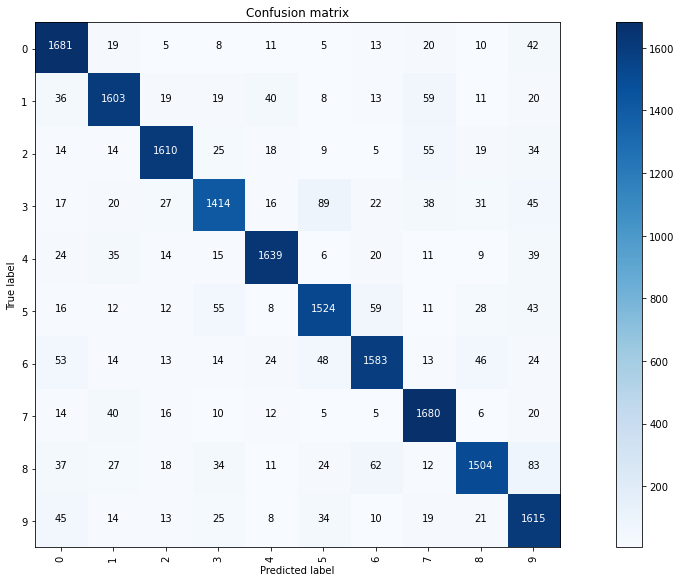

In [319]:
plt.figure(figsize=(16, 8))
Y_pred_classes21 = np.argmax(preda,axis = 1) 
# Convert validation observations to one hot vectors
Y_true21 = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx21 = confusion_matrix(Y_true21, Y_pred_classes21) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx21, classes = range(10)) 
print(confusion_mtx21)

    * True positives are impressive for all the classes. 

### Tuning of NN On CROPPED image

    Before finalizing the NN architecture, various combinations of below parameters were tested. 
        * Sigmoid, Relu, LeakyRelu and tanh Activations were tried. 
        * he_normal and glorot_uniform kernel initializers were tried.  
        * 0.1 to 0.5 Dropouts were tried.  
        * Multiple combinations of Hidden neurons were tried. 
        * Adam and sgd Optimizers(with different learning and decay paramters) were tried. 
        * Various epochs(100, 200, 300, 400, 500) were tried. 
        * Various batch_size(100, 150, 200) were tried. 
        * Various values of kernel_regularizers were tried. 
        
    Out of all these combinations, below architecture's accuracy is the highest. Therefore, retained the below architecture 
    and removed others.         

In [272]:
# finalized NN architecture for CROPPED image data
tf.keras.backend.clear_session()

modt2 = Sequential()
modt2.add(Dense(952, input_shape = (476, ), kernel_initializer='he_normal'))  #First hidden layer with 952 neurons, double the size of input neurons. 
modt2.add(BatchNormalization()) 
modt2.add(LeakyReLU(alpha=0.05)) #activation function Leakyrelu.
modt2.add(Dropout(0.3)) 

modt2.add(Dense(952, kernel_initializer='he_normal')) #Second hidden layer with 952 neurons. 
modt2.add(BatchNormalization()) 
modt2.add(LeakyReLU(alpha=0.05)) #activation function Leakyrelu.
modt2.add(Dropout(0.3))

modt2.add(Dense(10)) #output layer with 10 neurons since we have 10 different classes
modt2.add(Activation('softmax'))

adam1 = optimizers.Adam(lr = 0.001,beta_2=0.999, decay=0.001, amsgrad=False) # Updated Adam Optimizers default values 
modt2.compile(optimizer=adam1, loss='categorical_crossentropy', metrics=['accuracy'])
 
modt2.fit(X_train_ci, y_train, batch_size = 200, validation_data=(X_val_ci,y_val), epochs = 200) #200 epochs with batch size 200.

Train on 42000 samples, validate on 60000 samples
Epoch 1/200
42000/42000 [==============================] - 11s 253us/sample - loss: 1.2871 - accuracy: 0.5895 - val_loss: 1.2553 - val_accuracy: 0.6138
Epoch 2/200
42000/42000 [==============================] - 10s 230us/sample - loss: 0.8432 - accuracy: 0.7400 - val_loss: 1.0062 - val_accuracy: 0.6868
Epoch 3/200
42000/42000 [==============================] - 10s 231us/sample - loss: 0.7318 - accuracy: 0.7743 - val_loss: 0.9425 - val_accuracy: 0.6942
Epoch 4/200
42000/42000 [==============================] - 10s 234us/sample - loss: 0.6612 - accuracy: 0.7984 - val_loss: 0.7079 - val_accuracy: 0.7870
Epoch 5/200
42000/42000 [==============================] - 10s 234us/sample - loss: 0.6161 - accuracy: 0.8127 - val_loss: 0.7855 - val_accuracy: 0.7465
Epoch 6/200
42000/42000 [==============================] - 10s 237us/sample - loss: 0.5893 - accuracy: 0.8200 - val_loss: 0.6706 - val_accuracy: 0.7846
Epoch 7/200
42000/42000 [=============

42000/42000 [==============================] - 11s 271us/sample - loss: 0.2170 - accuracy: 0.9313 - val_loss: 0.2229 - val_accuracy: 0.9418
Epoch 108/200
42000/42000 [==============================] - 11s 271us/sample - loss: 0.2185 - accuracy: 0.9289 - val_loss: 0.2170 - val_accuracy: 0.9430
Epoch 109/200
42000/42000 [==============================] - 11s 272us/sample - loss: 0.2170 - accuracy: 0.9291 - val_loss: 0.2153 - val_accuracy: 0.9444
Epoch 110/200
42000/42000 [==============================] - 11s 270us/sample - loss: 0.2150 - accuracy: 0.9323 - val_loss: 0.2175 - val_accuracy: 0.9426
Epoch 111/200
42000/42000 [==============================] - 11s 270us/sample - loss: 0.2166 - accuracy: 0.9314 - val_loss: 0.2249 - val_accuracy: 0.9395
Epoch 112/200
42000/42000 [==============================] - 12s 274us/sample - loss: 0.2171 - accuracy: 0.9305 - val_loss: 0.2196 - val_accuracy: 0.9433
Epoch 113/200
42000/42000 [==============================] - 11s 270us/sample - loss: 0.21

In [274]:
tempz = modt2.evaluate(X_test_ci, y_test)

18000/18000 [==============================] - 3s 166us/sample - loss: 0.4386 - accuracy: 0.8911


In [299]:
temp_df = pd.DataFrame({'Models':['CI_2Lyrs_TN'], 'Accuracy': [tempz[1]]},index={'9'})
final_df= pd.concat([final_df, temp_df])
final_df = final_df[['Models', 'Accuracy']]
final_df

,Models,Accuracy
1,FI_1Lyr,0.814722
2,FI_1Lyr_Flatten,0.681556
3,CI_1Lyr,0.838056
4,FI_2Lyrs,0.824722
5,CI_2Lyrs,0.844278
6,FI_3Lyrs,0.823944
7,CI_3Lyrs,0.845889
8,FI_2Lyrs_TN,0.880722
9,CI_2Lyrs_TN,0.891056


**NN's on Cropped Image had accuracy of 84.5%, with Tuning ACCURACY INCREASED TO 89.1%. Significant increase in Accuracy.**

In [344]:
final_df = final_df.set_index('Models')

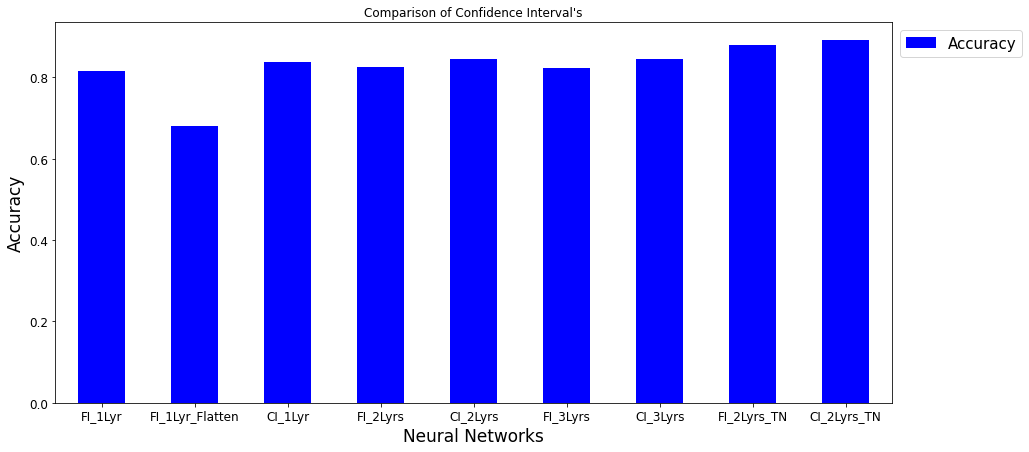

In [355]:
# Plot the bar chart

ax2 = final_df.plot(kind='bar',rot=0, figsize = (15,7), fontsize = 12,colormap="winter",
                  title="Comparison of Confidence Interval's")
ax2.legend(bbox_to_anchor=(1, 1), prop={'size': 15})
ax2.set_ylabel("Accuracy", fontsize=17)
ax2.set_xlabel("Neural Networks", fontsize=17)
plt.show()

**Bar chart shows Tuned NN(CI_2Lyrs_TN) built on Cropped image has the highest Accuracy.** 

In [301]:
predb = modt2.predict(X_test_ci)

[[1660   20   12   23   16    5   29   12   12   25]
 [  21 1606   24   36   51    8   20   31   22    9]
 [  13   10 1632   39   14   11    5   34   17   28]
 [   7   17   26 1496   11   81   19   16   27   19]
 [   9   31   11   35 1667    4   14   11    8   22]
 [   4    6   10   68    6 1583   45    9   17   20]
 [  33    9   15   18   24   65 1598    6   52   12]
 [  11   35   25   28   21   12   10 1648    7   11]
 [  20   20   24   52   10   25   57    7 1552   45]
 [  26   14   22   41   16   41   14   17   25 1588]]


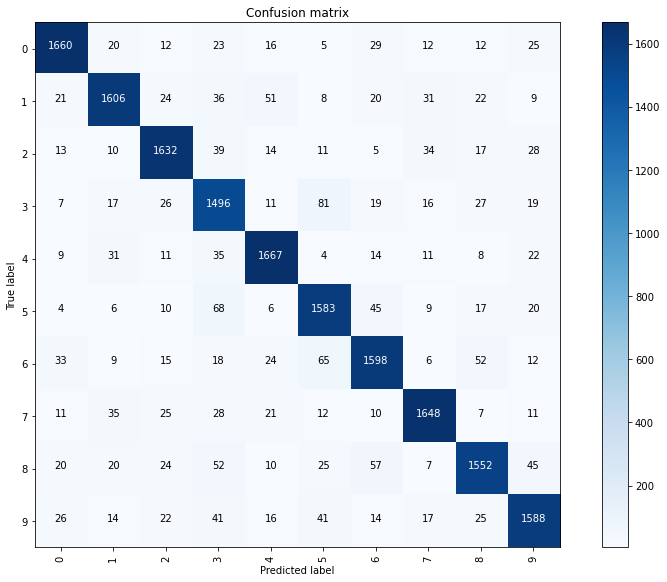

In [320]:
plt.figure(figsize=(12, 8))
Y_pred_classes21 = np.argmax(predb,axis = 1) 
# Convert validation observations to one hot vectors
Y_true21 = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx21 = confusion_matrix(Y_true21, Y_pred_classes21) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx21, classes = range(10)) 
print(confusion_mtx21)

**True positive(from Cropped Image NN) values are higher than True positive values from Full Image NN.**  

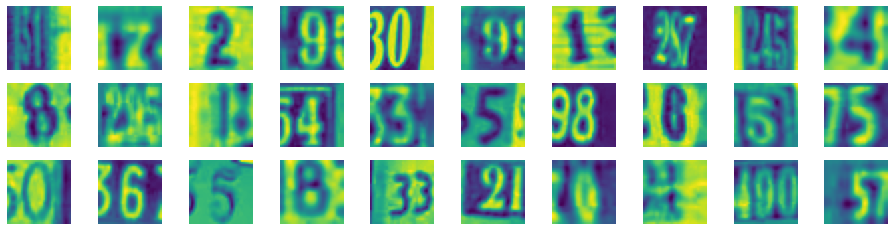

label for each of the above image: [1 7 2 9 0 9 1 8 4 4 8 9 1 4 3 5 8 6 5 5 0 6 5 8 3 2 0 1 9 5]


In [342]:
# visualizing the first 30 images in the dataset and their labels

plt.figure(figsize=(16, 4))
for i in range(30):
    plt.subplot(3, 10, i+1)
    plt.imshow(X_test1[i])
    plt.axis('off')
plt.show()
print('label for each of the above image: %s' % (y_test1[0:30]))

In [358]:
print("Predictions made by NN built on Cropped Image data - ")
modt2.predict_classes(X_test_temp)[0:30]

Predictions made by NN built on Cropped Image data - 


array([1, 7, 2, 9, 0, 9, 1, 6, 1, 4, 8, 2, 4, 4, 3, 5, 8, 6, 5, 5, 0, 6,
       5, 8, 3, 2, 6, 5, 9, 5], dtype=int64)

In [360]:
print("Predictions made by NN built on Full Image data - ")
modta.predict_classes(X_test_fi)[0:30]

Predictions made by NN built on Full Image data - 


array([1, 7, 2, 9, 0, 9, 1, 6, 1, 4, 8, 2, 1, 4, 3, 5, 8, 6, 5, 5, 0, 6,
       5, 8, 3, 2, 0, 2, 9, 5], dtype=int64)

    * Both the model(on Full Image and Cropped Image) predictions are similar for the first thirty images on test set.   

## Conclusion

The assignment is to build a Neural network to classify the labels in SVHN image dataset.  

SVHN dataset contains 42000, 18000 and 60000 images of Train, Validation and Test set respectively. There were noise in the images, like additional numbers were present in the images. Left and right side of the Images are cropped to minimize the noise. 
Neural networks (with different parameter combinations) are built on both full image and cropped image data.

**Tuned NN network built on Cropped image has the highest Accuracy (89.1%) followed by Tuned NN network accuracy (88%) built on full image**. 